In [ ]:
#%pip install tifffile
%pip install monai
%pip install datasets
%pip install -q git+https://github.com/huggingface/transformers.git
#%pip install -U ipywidgets==7.7.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

# Import Libraries

In [ ]:
from datasets import Dataset, load_dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from scipy import ndimage
import tifffile
from torch.utils.data import DataLoader
from torch.optim import Adam
import monai
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
from transformers import SamProcessor
from PIL import Image
import io

In [ ]:
sidewalk_train = load_dataset("back2classroom/sidewalks", split='train', streaming=True)
print(next(iter(sidewalk_train)))

sidewalk_test = load_dataset("back2classroom/sidewalks", split='val', streaming=True)
print(next(iter(sidewalk_test)))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


{'filename': '1001_10_1', 'tfw': b'1.0000000000\r\n0.0000000000\r\n0.0000000000\r\n1.0000000000\r\n0.0000000000\r\n2304.0000000000\r\n', 'tif': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x01\x00\x01\x00\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\

In [ ]:
#test_images = tifffile.imread("/workspaces/csgy6613-project/Test/*.tif")
#test_labels = tifffile.imread("/workspaces/csgy6613-project/Label/Test/*.tif")

In [ ]:
#test_images.shape

In [ ]:
train_images = []
train_labels = []

# Loop through the streamed dataset and collect images and masks
for sample in sidewalk_train:
    train_images.append(sample['tif'])
    train_labels.append(sample['label_tif'])

# Decode a JPEG byte string to a NumPy array
def decode_jpeg_to_array(jpeg_bytes):
    with io.BytesIO(jpeg_bytes) as byte_stream:
        image = Image.open(byte_stream)
        return np.array(image)

valid_indices = []
false_counter = 0

for i, mask_bytes in enumerate(train_labels):
    mask_np = decode_jpeg_to_array(mask_bytes)
    # Check if any pixel in the mask is not zero
    if np.any(mask_np != 0):
        valid_indices.append(i)
    else:
        false_counter += 1

print("Empty masks: ", false_counter)


filtered_images = [train_images[i] for i in valid_indices]
filtered_masks = [train_labels[i] for i in valid_indices]

Empty masks:  91137


In [ ]:
# Convert byte arrays to numpy arrays
def convert_to_numpy(byte_data):
    with io.BytesIO(byte_data) as byte_stream:
        image = Image.open(byte_stream)
        image_np = np.array(image)
        return image_np

In [ ]:
# Create a list to store the indices of non-empty masks
#valid_indices = [i for i, mask in enumerate(test_labels) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
#filtered_images = test_images[valid_indices]
#filtered_masks = test_labels[valid_indices]
#print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
#print("Mask shape:", filtered_masks.shape)

In [ ]:
# Store in original format
from datasets import Dataset

dataset_dict = {
    "image": filtered_images,  # Directly use the byte data
    "label": filtered_masks,   # Directly use the byte data
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

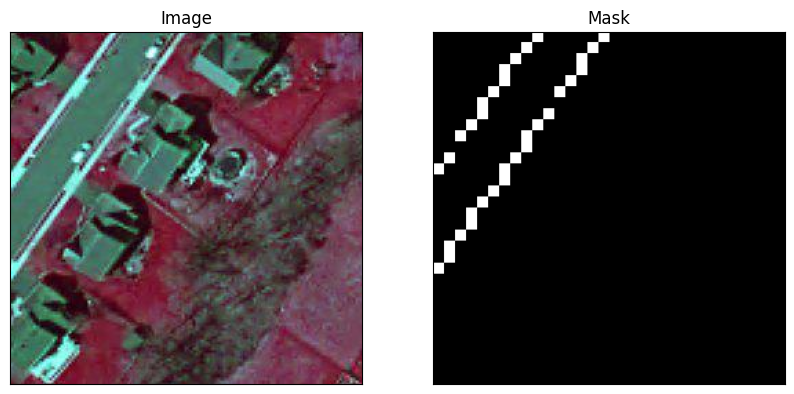

In [ ]:
img_num = random.randint(0, convert_to_numpy(filtered_images[0]).shape[0]-1)

image_np = convert_to_numpy(dataset[img_num]["image"])
mask_np = convert_to_numpy(dataset[img_num]["label"])

example_image = Image.fromarray(image_np)
example_mask = Image.fromarray(mask_np)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [ ]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [ ]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    # convert byte arrays to numpy arrays
    image_np = convert_to_numpy(item["image"])
    mask_np = convert_to_numpy(item["label"])

    image = Image.fromarray(image_np)
    ground_truth_mask = np.array(mask_np)

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [ ]:
# Initialize the processor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [ ]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=False)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items ():
    print(k, v.shape)

pixel_values torch.Size([8, 3, 1024, 1024])
original_sizes torch.Size([8, 2])
reshaped_input_sizes torch.Size([8, 2])
input_boxes torch.Size([8, 1, 4])
ground_truth_mask torch.Size([8, 256, 256])


In [ ]:
batch["ground_truth_mask"].shape

torch.Size([8, 256, 256])

In [ ]:
#NOTE: In order to import successfully I had to pip uninstall transformer-engine from outside the notebook.

from transformers import SamModel
# Load the model
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)


config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [ ]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
#Increased lr to account for higher batch_size of eight, original was set to 1e-5

optimizer = Adam(model.mask_decoder.parameters(), lr=0.001, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceFocalLoss(squared_pred=True, reduction='mean')

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 5

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

  0%|          | 20/11108 [00:50<7:49:11,  2.54s/it]


KeyboardInterrupt: 

In [ ]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), './model_checkpoint.pth')

# Inference

In [ ]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [ ]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_model.load_state_dict(torch.load("model_checkpoint.pth"))


<All keys matched successfully>

In [ ]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

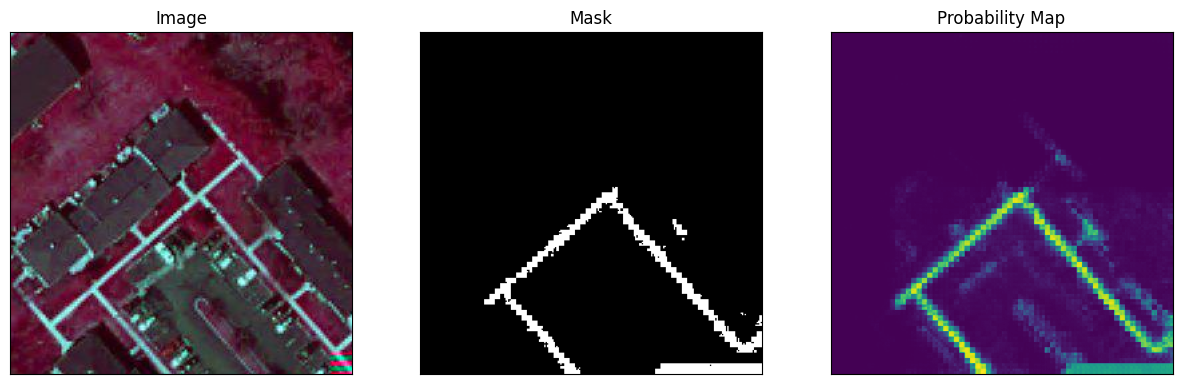

In [ ]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, filtered_images_np[0].shape[0]-1)

# load image
test_image = dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [ ]:
%pip install patchify

In [ ]:
from patchify import patchify

val_images = []
val_labels = []

# Loop through the streamed dataset and collect images and masks
for sample in sidewalk_test:
    val_images.append(sample['tif'])
    val_labels.append(sample['label_tif'])



# Decode a JPEG byte string to a NumPy array
def decode_jpeg_to_array(jpeg_bytes):
    with io.BytesIO(jpeg_bytes) as byte_stream:
        image = Image.open(byte_stream)
        return np.array(image)

valid_indices = []
false_counter = 0

for i, mask_bytes in enumerate(val_labels):
    mask_np = decode_jpeg_to_array(mask_bytes)
    # Check if any pixel in the mask is not zero
    if np.any(mask_np != 0):
        valid_indices.append(i)
    else:
        false_counter += 1

print("Empty masks: ", false_counter)

filtered_train_images = [val_images[i] for i in valid_indices]
filtered_train_masks = [val_labels[i] for i in valid_indices]
large_test_image = filtered_train_images[1]
patches = patchify(large_test_image, (256, 256), step=256)  #Step=256 for 256 patches means no overlap

Streaming output truncated to the last 5000 lines.
39010
39011
39012
39013
39014
39015
39016
39017
39018
39019
39020
39021
39022
39023
39024
39025
39026
39027
39028
39029
39030
39031
39032
39033
39034
39035
39036
39037
39038
39039
39040
39041
39042
39043
39044
39045
39046
39047
39048
39049
39050
39051
39052
39053
39054
39055
39056
39057
39058
39059
39060
39061
39062
39063
39064
39065
39066
39067
39068
39069
39070
39071
39072
39073
39074
39075
39076
39077
39078
39079
39080
39081
39082
39083
39084
39085
39086
39087
39088
39089
39090
39091
39092
39093
39094
39095
39096
39097
39098
39099
39100
39101
39102
39103
39104
39105
39106
39107
39108
39109
39110
39111
39112
39113
39114
39115
39116
39117
39118
39119
39120
39121
39122
39123
39124
39125
39126
39127
39128
39129
39130
39131
39132
39133
39134
39135
39136
39137
39138
39139
39140
39141
39142
39143
39144
39145
39146
39147
39148
39149
39150
39151
39152
39153
39154
39155
39156
39157
39158
39159
39160
39161
39162
39163
39164
39165
39166
39167
3

KeyboardInterrupt: 

In [ ]:
print("Number of images:", len(filtered_images_np))
if filtered_images_np:
    print("Shape of first image:", filtered_images_np[0].shape)


Number of images: 10082
Shape of first image: (256, 256, 3)
